In [1]:
import numpy as np
from Agents import *
from Environments import *
from Experiments import *
from Utils import *
from warnings import filterwarnings
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import pickle as cPickle

In [ ]:
EXPERIMENT = 'epochs'
GRIDWORLD = 'WILLEMSEN'
AGENT_TYPE = 'ME_Q'
PLOT = True
ANIMATE = False
MAX_STEPS = 10000
EPISODE_TIMEOUT = 33
GAMMA = 0.9
ALPHA = 0.1
RSS_ALPHA = 0.1
LIN_ALPHA = 0.0001
BATCH_SIZE = 10
WEIGHTS_METHOD = 'exp_size_corrected'
EXPLOIT = True
EPSILON = 0.1
EPOCHS = 100
dim2D = False if GRIDWORLD == "WILLEMSEN" else True
cwd = os.getcwd()
FOLDER = "%s\\Results" % (cwd)
FILE_SIG = f"{EXPERIMENT}_{AGENT_TYPE}_{GRIDWORLD}_n[{MAX_STEPS}]_alpha[{ALPHA}]_gamma[{GAMMA}]_batch[{BATCH_SIZE}]_weights[{WEIGHTS_METHOD}]_exploit[{EXPLOIT}]"
print(FILE_SIG)

In [ ]:
if GRIDWORLD == "WILLEMSEN":
    grid = np.ones((3, 9)) * -1
    grid[1, :8] = 0
    grid[1, 8] = 1
    grid[2, :8] = 0
    terminal_state = []
    for i in [0, 2]:
        for j in range(8):
            terminal_state.append([i, j])
    terminal_state.append([1, 8])
    # terminal_state.append([0, 8])
    # terminal_state.append([2, 8])
    terminal_state = np.array(terminal_state)
    initial_state = np.array([1, 0])
    blacked_state = np.array([[0, 8], [2, 8]])
elif GRIDWORLD == "STRAIGHT":
    grid = np.ones((3, 9)) * -1
    grid[1, :8] = 0
    grid[1, 8] = 1
    grid[2, :8] = 0.1
    terminal_state = []
    for i in [0]:
        for j in range(8):
            terminal_state.append([i, j])
    terminal_state.append([1, 8])
    # terminal_state.append([0, 8])
    # terminal_state.append([2, 8])
    terminal_state = np.array(terminal_state)
    initial_state = np.array([1, 0])
    blacked_state = np.array([[0, 8], [2, 8]])
elif GRIDWORLD == "POOL":
    grid = np.ones((8, 8)) * 0
    grid[3:6, 3:6] = -1
    grid[7, 7] = 1
    terminal_state = np.array([7, 7])
    initial_state = np.array([1, 0])
    blacked_state = np.array([[5, 5], [4, 5], [5, 4], [4, 4]])
    # blacked_state = np.array([[np.nan, np.nan], [np.nan, np.nan]])
elif GRIDWORLD == "STAR":
    grid = np.ones((15, 15)) * 0.1
    grid[7, 0] = -1
    grid[14, 7] = -1
    grid[7, 14] = 1
    grid[0, 7] = 1
    terminal_state = np.array([[7,0], [14,7], [7,14], [0,7]])
    initial_state = np.array([7,7])
    blacked_state = np.array([np.nan, np.nan])

env = Gridworld(grid, terminal_state, initial_state, blacked_state)
env_greedy = Gridworld(grid, terminal_state, initial_state, blacked_state)

if GRIDWORLD == "STRAIGHT" or GRIDWORLD=="WILLEMSEN":
    states = [(i, j) for i in [0, 1, 2] for j in range(env.grid_width)]
    env_shape = (3, env.grid_width)
elif GRIDWORLD == "POOL" or GRIDWORLD == "STAR":
    states = [(i, j) for i in range(env.grid_height) for j in range(env.grid_width)]
    env_shape = (env.grid_height, env.grid_width)
else:
    print("WORLD not found")

In [ ]:
AGENTS = {
    "SIMPLE_Q": SimpleQ,
    "ME_Q": MEQ,
    "NOVELTOR": Noveltor,
    "RMAX": RMAXQ,
    }

In [ ]:
# MAIN TRAINING and EVALUATION LOOP
M = []
for n in tqdm(range(EPOCHS)):
    agent = AGENTS[AGENT_TYPE](dim2D=dim2D)
    rb = ReplayMemory(max_size=10000)
    env.reset()
    env_greedy.reset()
    metrics, trajectories = train_and_eval(MAX_STEPS, BATCH_SIZE, agent, rb, env, env_greedy, states, env_shape, EXPLOIT)
    M.append(metrics)

In [2]:
# percentile based on
# http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html

# adapted according to empirical on
# https://github.com/LizaLebedeva/bootstrap-experiments/blob/master/bootstrap_methods.ipynb

def bootstrap_empirical(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    obs_metric = func(data) # compute CI center from data directly
#     simulations = simulations - obs_metric # now move bootstrap to differences
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        percentile_upper = simulations[l_indx]
        percentile_lower = simulations[u_indx]
        empirical_lower = 2*obs_metric - percentile_lower
        empirical_upper = 2*obs_metric - percentile_upper
        return(empirical_lower,empirical_upper)
    return(ci)

In [ ]:
R = np.zeros((EPOCHS, MAX_STEPS, 2))

for i, epoch in enumerate(M):
    for j, metrics in enumerate(epoch):
        for exp, g in enumerate(metrics['Gn']):
            R[i,j, 0] += GAMMA**exp*g
        for exp, g in enumerate(metrics['Gg']):
            R[i,j, 1] += GAMMA**exp*g

In [ ]:
Rn = R[:,:,0]
Rg = R[:,:,1]
yn = np.mean(Rn, axis=0)
yg = np.mean(Rg, axis=0)
yCIn = list(map(lambda p: bootstrap_empirical(p)(0.95), Rn.T))
yCIg = list(map(lambda p: bootstrap_empirical(p)(0.95), Rg.T))
Yn = np.transpose(yCIn)
Yg = np.transpose(yCIg)

In [ ]:
%matplotlib inline
x = np.arange(0, MAX_STEPS, 1)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(x, yn, label='exploring')
ax.fill_between(x, Yn[0], Yn[1], color='teal', alpha=.2)

plt.plot(x, yg, label='exploiting')
ax.fill_between(x, Yg[0], Yg[1], color='purple', alpha=.2)

plt.ylabel('cumulative discounted reward')
plt.xlabel('episode')

plt.legend()
plt.savefig(f'results/{FILE_SIG}_exploit.png')
plt.show()

In [ ]:
with open('%s.txt'%FILE_SIG, 'wb') as fh:
    cPickle.dump(M, fh)

## Loading Previously Pickled Files for plotting

In [ ]:
# load me q willemsen
FILE_SIG = "epochs_ME_Q_WILLEMSEN_n[10000]_alpha[0.1]_gamma[0.9]_batch[10]_weights[exp_size_corrected]_exploit[True]"
with open (f'results/{FILE_SIG}.txt', 'rb') as fh:
    M = cPickle.load(fh)

In [ ]:
# load simple q willemsen
FILE_SIG = "epochs_SIMPLE_Q_WILLEMSEN_n[10000]_alpha[0.1]_gamma[0.9]_batch[10]_weights[exp_size_corrected]_exploit[True]"
with open (f'results/{FILE_SIG}.txt', 'rb') as fh:
    M = cPickle.load(fh)

In [ ]:
M[90][1000].items()

## Loading Temp Folder

In [3]:
import glob

In [28]:
M = []

In [29]:
for file in glob.glob('C:\\Users\\CesareCarissimo\\Documents\\MARL\\RapidRL\\Results\\temp_epochs\\*.txt', recursive=True):
    with open (file, 'rb') as fh:
        run = cPickle.load(fh)
        M.append(run)

In [30]:
R = np.zeros((100, 10000))

for i, epoch in enumerate(M):
    for j, metrics in enumerate(epoch):
        for exp, g in enumerate(metrics['Gn']):
            R[i,j] += 0.9**exp*g

In [31]:
yn = np.mean(R, axis=0)
yCIn = list(map(lambda p: bootstrap_empirical(p)(0.95), R.T))
Yn = np.transpose(yCIn)

In [32]:
Rg = np.empty((100, 10000))

for i, epoch in enumerate(M):
    for j, metrics in enumerate(epoch):
        if metrics['Gg'] != None:
            for exp, g in enumerate(metrics['Gg']):
                Rg[i,j] += 0.9**exp*g

In [33]:
yg = np.mean(Rg, axis=0)
yCIg = list(map(lambda p: bootstrap_empirical(p)(0.95), Rg.T))
Yg = np.transpose(yCIg)

### Saving Processed Results

In [34]:
results = (yn, yCIn, Yn, yg, yCIg, Yg)

In [35]:
with open ('Results/results_noveltor_willemsen_adjusted', 'wb') as file:
    cPickle.dump(results, file)

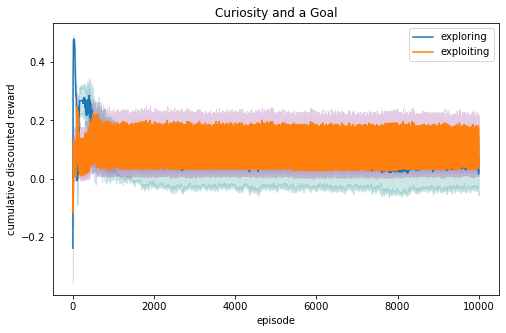

In [37]:
%matplotlib inline

truncated = 10000  # max, max_steps
x = np.arange(0, truncated, 1)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(x, yn[:truncated], label='exploring')
ax.fill_between(x, Yn[0,:truncated], Yn[1,:truncated], color='teal', alpha=.2)

plt.plot(x, yg[:truncated], label='exploiting')
ax.fill_between(x, Yg[0,:truncated], Yg[1,:truncated], color='purple', alpha=.2)

plt.ylabel('cumulative discounted reward')
plt.xlabel('episode')

plt.title('Curiosity and a Goal')

plt.legend()
plt.savefig(f'results/epochs_noveltor_adjusted_WILLEMSEN_truncated[%i]_n[10000]_alpha[0.1]_gamma[0.9]_batch[10]_weights[exp_size_corrected]_exploit[True].png' % ( truncated ))
plt.show()

### Load Processed Results

In [39]:
with open ('Results/results_simpleq_willemsen_exploit', 'rb') as file:
    simple = cPickle.load(file)

In [40]:
with open ('Results/results_meq_willemsen_adjusted', 'rb') as file:
    me = cPickle.load(file)

In [41]:
with open ('Results/results_noveltor_willemsen_adjusted', 'rb') as file:
    nov = cPickle.load(file)

In [42]:
with open ('Results/results_pseudocount_willemsen_adjusted', 'rb') as file:
    pse = cPickle.load(file)

In [43]:
# pickled_file = (yn, yCIn, Yn, yg, yCIg, Yg)

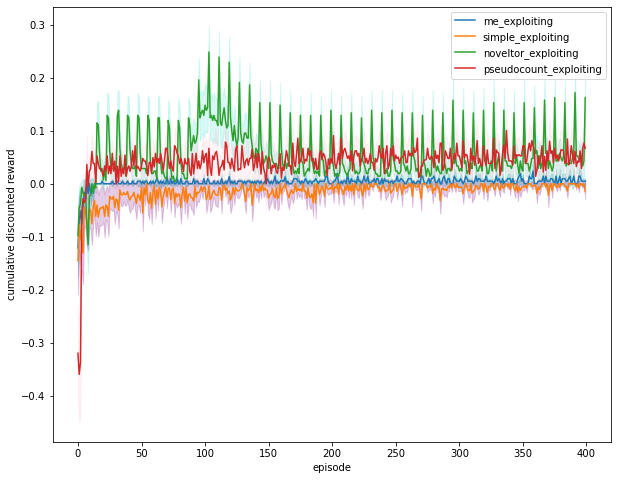

In [50]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,8))
explore = False
lim = (0, 400)

x = np.arange(lim[0], lim[1], 1)

if explore:
    plt.plot(x, me[0][lim[0]:lim[1]], label='me_exploring')
    ax.fill_between(x, me[2][0, lim[0]:lim[1]], me[2][1, lim[0]:lim[1]], color='teal', alpha=.2)

    plt.plot(x, simple[0][lim[0]:lim[1]], label='simple_exploring')
    ax.fill_between(x, simple[2][0, lim[0]:lim[1]], simple[2][1, lim[0]:lim[1]], color='purple', alpha=.2)
    
    plt.plot(x, nov[0][lim[0]:lim[1]], label='noveltor_exploring')
    ax.fill_between(x, nov[2][0, lim[0]:lim[1]], nov[2][1, lim[0]:lim[1]], color='turquoise', alpha=.2)
    
    plt.plot(x, pse[0][lim[0]:lim[1]], label='pseudocount_exploring')
    ax.fill_between(x, pse[2][0, lim[0]:lim[1]], pse[2][1, lim[0]:lim[1]], color='pink', alpha=.2)
else:
    plt.plot(x, me[3][lim[0]:lim[1]], label='me_exploiting')
    ax.fill_between(x, me[5][0, lim[0]:lim[1]], me[5][1, lim[0]:lim[1]], color='teal', alpha=.2)

    plt.plot(x, simple[3][lim[0]:lim[1]], label='simple_exploiting')
    ax.fill_between(x, simple[5][0, lim[0]:lim[1]], simple[5][1, lim[0]:lim[1]], color='purple', alpha=.2)
    
    plt.plot(x, nov[3][lim[0]:lim[1]], label='noveltor_exploiting')
    ax.fill_between(x, nov[5][0, lim[0]:lim[1]], nov[5][1, lim[0]:lim[1]], color='turquoise', alpha=.2)
    
    plt.plot(x, pse[3][lim[0]:lim[1]], label='pseudocount_exploiting')
    ax.fill_between(x, pse[5][0, lim[0]:lim[1]], pse[5][1, lim[0]:lim[1]], color='pink', alpha=.2)

plt.ylabel('cumulative discounted reward')
plt.xlabel('episode')

plt.legend()
plt.savefig(f'results/combined_adjusted_%s_WILLEMSEN_n[%i_to_%i]_alpha[0.1]_gamma[0.9]_batch[10]_weights[exp_size_corrected]_exploit[True].png' % ('explore' if explore else 'exploit', lim[0], lim[1]))
plt.show()